# Corpus Sampling


## 1. Reproducibility and configuration


In [74]:
# --- Imports ---
from __future__ import annotations

import os
import random
from pathlib import Path

import numpy as np
import pandas as pd
from datetime import datetime

import matplotlib.pyplot as plt

# --- Random seed ---
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)

print("SEED =", SEED)


SEED = 42


In [91]:

# --- Paths ---
PROJECT_ROOT = Path("/Users/eugenia/Desktop/thesis/magic_tagger")

INDEX_DIR = PROJECT_ROOT / "docs" / "index"
INDEX_DIR.mkdir(parents=True, exist_ok=True)

# Input index location 
INDEX_CANDIDATES = [
    PROJECT_ROOT / "data" /"index" / "corpus_a_index_clean_atu_metadata.xlsx"
]

OUT_XLSX = (PROJECT_ROOT / "data" / "index" / f"corpus_b_{SAMPLING_VERSION}.xlsx").resolve()

def pick_first_existing(paths: list[Path]) -> Path:
    for p in paths:
        if p.exists():
            return p
    raise FileNotFoundError(f"No index file found in candidates:\n" + "\n".join(map(str, paths)))

INDEX_PATH = pick_first_existing(INDEX_CANDIDATES)
FIG_DIR = PROJECT_ROOT / "notebooks" / "figures"

print("PROJECT_ROOT:", PROJECT_ROOT)
print("INDEX_PATH:", INDEX_PATH)


PROJECT_ROOT: /Users/eugenia/Desktop/thesis/magic_tagger
INDEX_PATH: /Users/eugenia/Desktop/thesis/magic_tagger/data/index/corpus_a_index_clean_atu_metadata.xlsx


In [76]:
# Sampling settings
CORE_K = 2                      # texts per type for core set
COVERAGE_N = None            
COVERAGE_RATE = 0.15

# Version tag 
SAMPLING_VERSION = f"v1_{datetime.now().strftime('%Y%m%d')}"

# Sanity checks
if (COVERAGE_N is None) == (COVERAGE_RATE is None):
    raise ValueError("Set exactly one of COVERAGE_N or COVERAGE_RATE (the other must be None).")

print("\nParameters:")
print(" CORE_K:", CORE_K)
print(" COVERAGE_N:", COVERAGE_N)
print(" COVERAGE_RATE:", COVERAGE_RATE)
print(" SAMPLING_VERSION:", SAMPLING_VERSION)



Parameters:
 CORE_K: 2
 COVERAGE_N: None
 COVERAGE_RATE: 0.15
 SAMPLING_VERSION: v1_20251230


## 2. Load corpus index / metadata table

In [77]:
xls = pd.ExcelFile(INDEX_PATH)
print("Sheets:", xls.sheet_names)

df_master = xls.parse(xls.sheet_names[0], dtype=str)  # первый лист
print("Loaded:", INDEX_PATH)
print("Shape:", df_master.shape)
df_master.head()

Sheets: ['veneime13102025']
Loaded: /Users/eugenia/Desktop/thesis/magic_tagger/data/index/corpus_a_index_clean_atu_metadata.xlsx
Shape: (112, 36)


,tale_id,collection,volume_no,source_ref,digital_carrier,rights_status,narrator,collector_1,collector_2,collector_3,...,local_type,type_code_1,type_code_2,type_code_3,type_code_4,mapping_status,mapping_relation,mapping_date,mapping_by,gold_status
0,era_vene_2_605_4,"ERA, Vene",2,"ERA, Vene 2, 605/21 (4)",scan_only,open,"Nimi: Денисиха, Vanus/Sünniaasta: 75 л.",Koniaev Fedor,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,missing,exact,20.12.2025,Evgeniia Vdovichenko,missing
1,era_vene_5_167_9,"ERA, Vene",5,"ERA, Vene 5, 167/9 (9)",scan_only,open,NaN,Valkevits Nina,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,missing,exact,20.12.2025,Evgeniia Vdovichenko,missing
2,era_vene_6_379_6,"ERA, Vene",6,"ERA, Vene 6, 379/81",scan_only,open,"Nimi: Lewonty Borhov, Vanus/Sünniaasta: 63 a.",Sokolov M.,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,missing,exact,20.12.2025,Evgeniia Vdovichenko,missing
3,era_vene_7_125_1,"ERA, Vene",7,"ERA, Vene 7, 125/8 (1)",scan_only,open,"Nimi: Александр Кельнер, Märkus: слышал от баб...",Kelner Aleksandr,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,missing,exact,20.12.2025,Evgeniia Vdovichenko,missing
4,rkm_vene_3_257_116,"RKM, Vene",3,"RKM, Vene 3, 257/62 (116)",scan_only,open,"Nimi: Анастасия Кодар, Vanus/Sünniaasta: 1909,...",Gildebrandt Olga,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,missing,exact,20.12.2025,Evgeniia Vdovichenko,missing


## 3. Define sampling rules 

1. **Core set (comparability-first).**  
   Include **all texts** whose tale type occurs in the corpus **at least twice** (i.e., `count(type_code_1) ≥ 2`).  
   *Rationale:* this guarantees that every included type supports intra-type comparison (at least two attestations).

2. **Coverage set (diversity slice).**  
   From the remaining texts that belong to **singleton types** (i.e., `count(type_code_1) = 1`), add a **random 15% sample**.  
   *Rationale:* this preserves thematic breadth and prevents the v1 corpus from being biased toward only the most frequent types.

## 4. Build the Core set 

In [92]:
TYPE_COL = "type_code_1"
TEXT_ID_COL = "tale_id"

df = df_master.copy()

# Clean type (ok as string)
df[TYPE_COL] = df[TYPE_COL].astype("string").str.strip()

# Drop empty type codes
df = df[df[TYPE_COL].notna() & (df[TYPE_COL] != "")].copy()

# Compute type frequencies
type_counts = (
    df.groupby(TYPE_COL, dropna=False)[TEXT_ID_COL]
      .size()
      .rename("type_count")
      .reset_index()
)

df = df.merge(type_counts, on=TYPE_COL, how="left")

# Split core vs singletons
core = df[df["type_count"] >= 2].copy()
singletons = df[df["type_count"] == 1].copy()

core["set"] = "core"

# Coverage sample
n_cov = int(np.ceil(len(singletons) * COVERAGE_RATE))
coverage = singletons.sample(n=n_cov, random_state=SEED) if n_cov > 0 else singletons.head(0).copy()
coverage["set"] = "coverage"

selected = pd.concat([core, coverage], ignore_index=True)

# Final checks
selected_out = selected.drop_duplicates(subset=[TEXT_ID_COL]).copy()
selected_out["sampling_version"] = SAMPLING_VERSION
selected_out["coverage_rate"] = COVERAGE_RATE

with pd.ExcelWriter(OUT_XLSX, engine="openpyxl") as w:
    selected_out.to_excel(w, sheet_name="corpus_b", index=False)

print("Saved:", OUT_XLSX)

print("Selected texts:", len(selected_out))
print("Core texts:", (selected_out["set"] == "core").sum())
print("Coverage texts:", (selected_out["set"] == "coverage").sum())
print("Unique selected types:", selected_out[TYPE_COL].nunique())

Saved: /Users/eugenia/Desktop/thesis/magic_tagger/data/index/corpus_b_v1_20251230.xlsx
Selected texts: 61
Core texts: 55
Coverage texts: 6
Unique selected types: 25


In [79]:
selected_out.tail(10)

,tale_id,collection,volume_no,source_ref,digital_carrier,rights_status,narrator,collector_1,collector_2,collector_3,...,type_code_4,mapping_status,mapping_relation,mapping_date,mapping_by,gold_status,type_count,set,sampling_version,coverage_rate
51,tru_vkk_13_23_2,"TRÜ, VKK",13,"TRÜ, VKK 13, 23/6 (2)",scan_only,restricted_anon,"nar012, Vanus/Sünniaasta: 80 л.",col025,col029,col033,...,NaN,not_needed_native_atu,exact,20.12.2025,Evgeniia Vdovichenko,ok,2,core,v1_20251230,0.15
52,tru_vkk_13_31_2,"TRÜ, VKK",13,"TRÜ, VKK 13, 31/46 (2)",scan_only,restricted_anon,"nar011, Vanus/Sünniaasta: 39 л.",col025,col031,NaN,...,NaN,not_needed_native_atu,exact,20.12.2025,Evgeniia Vdovichenko,ok,2,core,v1_20251230,0.15
53,tru_vkk_13_59_4,"TRÜ, VKK",13,"TRÜ, VKK 13, 59/80 (4)",scan_only,restricted_anon,"nar011, Vanus/Sünniaasta: 39 л.",col025,col033,NaN,...,556F*,not_needed_native_atu,exact,20.12.2025,Evgeniia Vdovichenko,ok,4,core,v1_20251230,0.15
54,tru_vkk_29_54_68,"TRÜ, VKK",29,"TRÜ, VKK 29, 54/67 (68)",transcript_only,restricted_anon,"nar005, Vanus/Sünniaasta: около 60 л.",col009,col017,col020,...,NaN,mapped_from_local,broad,20.12.2025,Evgeniia Vdovichenko,ok,6,core,v1_20251230,0.15
55,rkm_vene_1_236_5,"RKM, Vene",1,"RKM, Vene 1, 236/44 (5)",scan_only,open,"Nimi: Анна Терентьевна Гунина, Vanus/Sünniaast...",Voogla Vera,NaN,NaN,...,NaN,not_needed_native_atu,exact,20.12.2025,Evgeniia Vdovichenko,ok,1,coverage,v1_20251230,0.15
56,tru_vkk_25_120_23,"TRÜ, VKK",25,"TRÜ, VKK 25, 120/4 (23)",transcript_only,restricted_anon,NaN,col003,col004,col007,...,NaN,not_needed_native_atu,exact,20.12.2025,Evgeniia Vdovichenko,ok,1,coverage,v1_20251230,0.15
57,era_vene_13_635_20,"ERA, Vene",13,"ERA, Vene 13, 635/8 (20)",scan_only,open,"Nimi: Иван Мишин, Vanus/Sünniaasta: 50 л.",Zhemchuzhina Zoya,NaN,NaN,...,NaN,not_needed_native_atu,exact,20.12.2025,Evgeniia Vdovichenko,ok,1,coverage,v1_20251230,0.15
58,era_vene_1_515_1,"ERA, Vene",1,"ERA, Vene 1, 515/6 (1)",scan_only,open,Nimi: Сергей Димитриевич Цветков,Tsvetkov Sergei Dimitrievich,NaN,NaN,...,NaN,mapped_from_local,broad,20.12.2025,Evgeniia Vdovichenko,ok,1,coverage,v1_20251230,0.15
59,era_vene_13_73_9,"ERA, Vene",13,"ERA, Vene 13, 73/9 (9)",scan_only,open,"Nimi: Мария Латкина, Vanus/Sünniaasta: 76 л.",Zhemchuzhina Zoya,NaN,NaN,...,NaN,not_needed_native_atu,exact,20.12.2025,Evgeniia Vdovichenko,ok,1,coverage,v1_20251230,0.15
60,era_vene_13_272_23,"ERA, Vene",13,"ERA, Vene 13, 272/93 (23)",scan_only,open,"Nimi: Матрена Протаева, Vanus/Sünniaasta: 85 л...",Zhemchuzhina Zoya,NaN,NaN,...,NaN,not_needed_native_atu,exact,20.12.2025,Evgeniia Vdovichenko,ok,1,coverage,v1_20251230,0.15


## 5. Sampling diagnostics

In [80]:
# --- Verify: exactly 2 per type ---
core_only = selected_out[selected_out["set"] == "core"].copy()

core_counts = core_only.groupby(TYPE_COL)[TEXT_ID_COL].nunique().rename("n_texts_core").reset_index()

print("Core types total:", core_counts.shape[0])

Core types total: 19


In [81]:
VOLUME_COL = "volume_no" 
YEAR_COL = "recorded_date_start"

# --- Check variation within type by volume/year ---
def variation_report(df_in: pd.DataFrame, col: str, label: str):
    if col not in df_in.columns:
        print(f"[skip] {label}: column '{col}' not present")
        return None

    tmp = df_in.copy()
    tmp[col] = tmp[col].astype("string").str.strip()
    grp = tmp.groupby(TYPE_COL)[col].nunique(dropna=True).rename(f"n_{label}_core").reset_index()
    grp[f"has_{label}_variation"] = grp[f"n_{label}_core"] >= 2

    print(f"\n{label} variation among core types:")
    print(" - types with >=2 distinct values:", int(grp["has_"+label+"_variation"].sum()), "/", grp.shape[0])
    display(grp.sort_values(f"n_{label}_core").head(10))  # smallest first (problematic)

    return grp

vol_var = variation_report(core_only, VOLUME_COL, "volume")
year_var = variation_report(core_only, YEAR_COL, "year")


volume variation among core types:
 - types with >=2 distinct values: 16 / 19


,type_code_1,n_volume_core,has_volume_variation
1,301,1,False
15,703*,1,False
14,700,1,False
0,300,2,True
16,706,2,True
8,480A,2,True
7,425C,2,True
18,735A,2,True
5,331,2,True
4,313,2,True



year variation among core types:
 - types with >=2 distinct values: 17 / 19


,type_code_1,n_year_core,has_year_variation
15,703*,1,False
14,700,1,False
0,300,2,True
16,706,2,True
8,480A,2,True
7,425C,2,True
18,735A,2,True
5,331,2,True
4,313,2,True
2,303,2,True


**Core set diversity check.** The core sample contains 19 tale types. Within-type documentary diversity is high: 16/19 types (≈84%) include two texts from different volumes, and 17/19 types (≈89%) include two texts from different years. 


In [82]:
def save_fig(name: str):
    """Save current matplotlib figure into notebooks/figures as PNG."""
    out = FIG_DIR / f"{name}.png"
    plt.tight_layout()
    plt.savefig(out, dpi=200, bbox_inches="tight")
    print("Saved:", out)

Saved: /Users/eugenia/Desktop/thesis/magic_tagger/notebooks/figures/texts_per_type_full_vs_selected.png


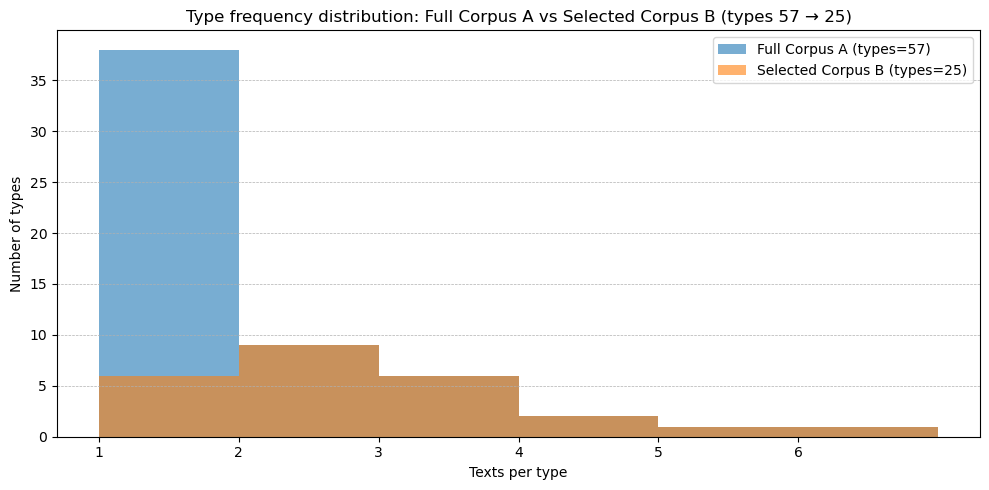

In [83]:
# --- clean minimal ---
full = df_master[[TYPE_COL, TEXT_ID_COL]].copy()
full[TYPE_COL] = full[TYPE_COL].astype("string").str.strip()
full[TEXT_ID_COL] = full[TEXT_ID_COL].astype("string").str.strip()
full = full[(full[TYPE_COL].notna()) & (full[TYPE_COL] != "") & (full[TEXT_ID_COL].notna())].copy()

sel = selected_out[[TYPE_COL, TEXT_ID_COL]].copy()
sel[TYPE_COL] = sel[TYPE_COL].astype("string").str.strip()
sel[TEXT_ID_COL] = sel[TEXT_ID_COL].astype("string").str.strip()
sel = sel[(sel[TYPE_COL].notna()) & (sel[TYPE_COL] != "") & (sel[TEXT_ID_COL].notna())].copy()

# --- counts: texts per type ---
full_counts = full.groupby(TYPE_COL)[TEXT_ID_COL].nunique()
sel_counts = sel.groupby(TYPE_COL)[TEXT_ID_COL].nunique()

n_types_full = int(full_counts.shape[0])
n_types_sel = int(sel_counts.shape[0])

# bins (cap long tail for readability)
max_bin = int(max(full_counts.max() if n_types_full else 1, sel_counts.max() if n_types_sel else 1))
cap = min(max_bin, 20)
bins = np.arange(1, cap + 2)

full_plot = np.clip(full_counts.values, 1, cap)
sel_plot = np.clip(sel_counts.values, 1, cap)

plt.figure(figsize=(10, 5))
plt.hist(full_plot, bins=bins, alpha=0.6, label=f"Full Corpus A (types={n_types_full})")
plt.hist(sel_plot, bins=bins, alpha=0.6, label=f"Selected Corpus B (types={n_types_sel})")

plt.xlabel(f"Texts per type")
plt.ylabel("Number of types")
plt.title(f"Type frequency distribution: Full Corpus A vs Selected Corpus B (types {n_types_full} → {n_types_sel})")
plt.xticks(bins[:-1])
plt.grid(True, axis="y", linestyle="--", linewidth=0.5)
plt.legend()

save_fig("texts_per_type_full_vs_selected")
plt.show()

Saved: /Users/eugenia/Desktop/thesis/magic_tagger/notebooks/figures/collector_coverage_full_vs_selected.png


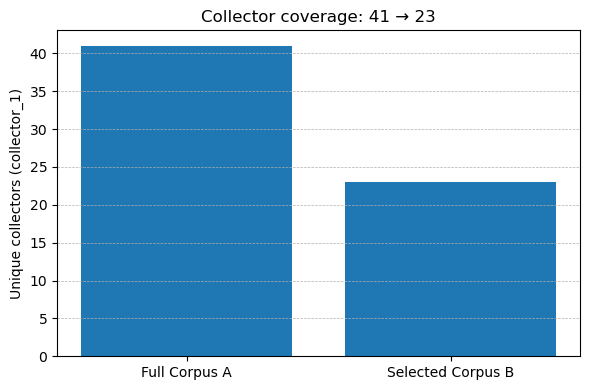

In [84]:
COLLECTOR_COL = "collector_1"

def _clean_subset(df, cols):
    d = df[cols].copy()
    for c in cols:
        d[c] = d[c].astype("string").str.strip()
        d[c] = d[c].replace({"": pd.NA, "nan": pd.NA, "NaN": pd.NA, "None": pd.NA})
    return d

full = _clean_subset(df_master, [TEXT_ID_COL, COLLECTOR_COL, VOLUME_COL, YEAR_COL])
sel  = _clean_subset(selected_out, [TEXT_ID_COL, COLLECTOR_COL, VOLUME_COL, YEAR_COL])

# ensure we count only valid texts
full = full[full[TEXT_ID_COL].notna()].copy()
sel  = sel[sel[TEXT_ID_COL].notna()].copy()

# ---------------------------
# collectors coverage (full vs selected)
# ---------------------------
n_coll_full = int(full[COLLECTOR_COL].dropna().nunique()) if COLLECTOR_COL in full.columns else 0
n_coll_sel  = int(sel[COLLECTOR_COL].dropna().nunique())  if COLLECTOR_COL in sel.columns else 0

plt.figure(figsize=(6, 4))
plt.bar(["Full Corpus A", "Selected Corpus B"], [n_coll_full, n_coll_sel])
plt.ylabel("Unique collectors (collector_1)")
plt.title(f"Collector coverage: {n_coll_full} → {n_coll_sel}")
plt.grid(True, axis="y", linestyle="--", linewidth=0.5)
save_fig("collector_coverage_full_vs_selected")  
plt.show()


Saved: /Users/eugenia/Desktop/thesis/magic_tagger/notebooks/figures/corpusB_texts_per_collector.png


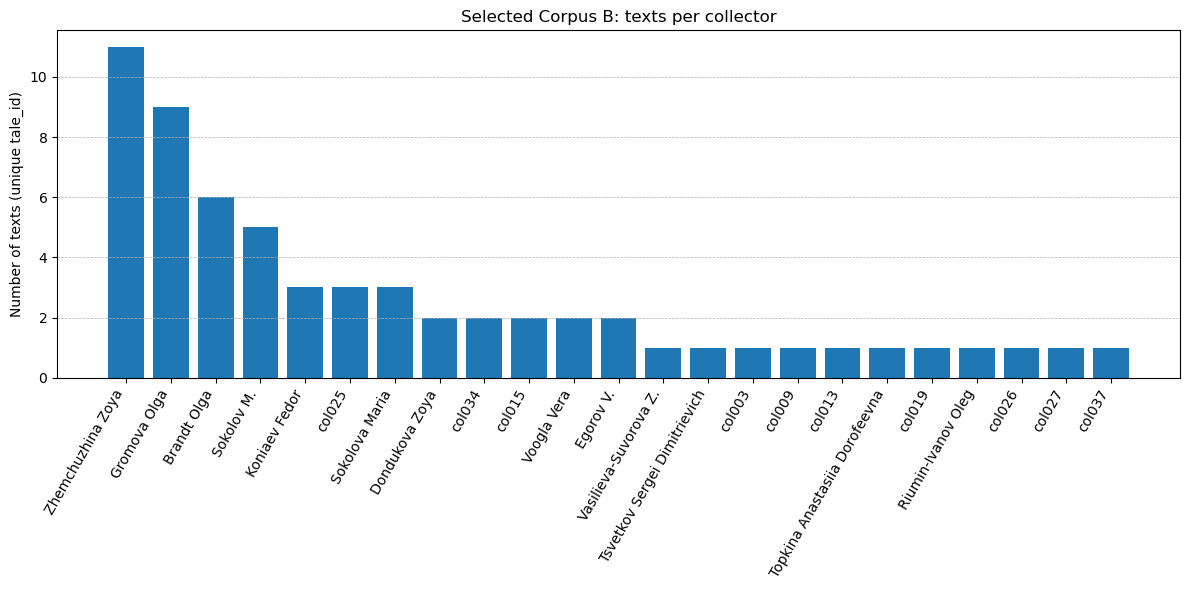

Total collectors in Selected Corpus B: 23
Total texts in Selected Corpus B: 61


In [85]:
# --- clean ---
d = selected_out[[TEXT_ID_COL, COLLECTOR_COL]].copy()
d[TEXT_ID_COL] = d[TEXT_ID_COL].astype("string").str.strip()
d[COLLECTOR_COL] = d[COLLECTOR_COL].astype("string").str.strip()

d = d[d[TEXT_ID_COL].notna()].copy()

# --- counts: texts per collector ---
collector_counts = (
    d.dropna(subset=[COLLECTOR_COL])
     .groupby(COLLECTOR_COL)[TEXT_ID_COL]
     .nunique()
     .sort_values(ascending=False)
)

plt.figure(figsize=(12, 6))
plt.bar(collector_counts.index.astype(str), collector_counts.values)
plt.ylabel("Number of texts (unique tale_id)")
plt.title(f"Selected Corpus B: texts per collector")
plt.xticks(rotation=60, ha="right")
plt.grid(True, axis="y", linestyle="--", linewidth=0.5)

save_fig("corpusB_texts_per_collector")  
plt.show()

print("Total collectors in Selected Corpus B:", int(collector_counts.shape[0]))
print("Total texts in Selected Corpus B:", int(d[TEXT_ID_COL].nunique()))

Saved: /Users/eugenia/Desktop/thesis/magic_tagger/notebooks/figures/volume_year_coverage_full_vs_selected.png


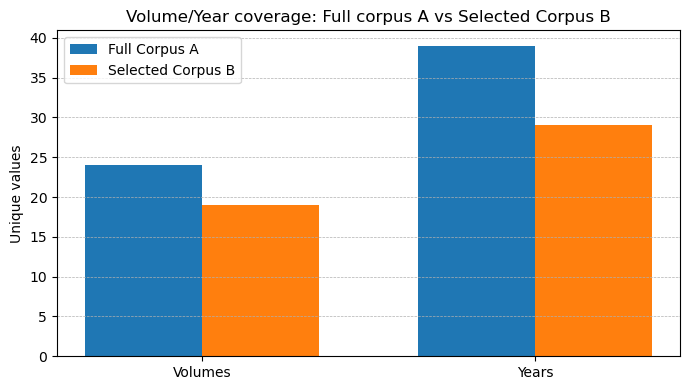

In [86]:
# volumes and years coverage (full vs selected)
# ---------------------------
n_vol_full = int(full[VOLUME_COL].dropna().nunique()) if VOLUME_COL in full.columns else 0
n_vol_sel  = int(sel[VOLUME_COL].dropna().nunique())  if VOLUME_COL in sel.columns else 0

n_year_full = int(full[YEAR_COL].dropna().nunique()) if YEAR_COL in full.columns else 0
n_year_sel  = int(sel[YEAR_COL].dropna().nunique())  if YEAR_COL in sel.columns else 0

x = [0, 1]
w = 0.35

plt.figure(figsize=(7, 4))
plt.bar([i - w/2 for i in x], [n_vol_full, n_year_full], width=w, label="Full Corpus A")
plt.bar([i + w/2 for i in x], [n_vol_sel,  n_year_sel],  width=w, label="Selected Corpus B")
plt.xticks(x, ["Volumes", "Years"])
plt.ylabel("Unique values")
plt.title("Volume/Year coverage: Full corpus A vs Selected Corpus B")
plt.grid(True, axis="y", linestyle="--", linewidth=0.5)
plt.legend()
save_fig("volume_year_coverage_full_vs_selected") 
plt.show()